In [1]:
import os
import glob
import gc
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch: {torch.__version__}")
print(f"OpenCV: {cv2.__version__}")
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.8.0+cu126
OpenCV: 4.12.0
Device: cuda
GPU: Tesla T4


In [2]:
# Paths
BASE_PATH = "/kaggle/input/pixel-play-26"
DATA_ROOT = os.path.join(BASE_PATH, os.listdir(BASE_PATH)[0])
AVENUE_PATH = os.path.join(DATA_ROOT, "Avenue_Corrupted", "Dataset")
TRAIN_VIDEOS = os.path.join(AVENUE_PATH, "training_videos")
TEST_VIDEOS = os.path.join(AVENUE_PATH, "testing_videos")
OUTPUT_DIR = "/kaggle/working"

print(f"Train exists: {os.path.exists(TRAIN_VIDEOS)}")
print(f"Test exists: {os.path.exists(TEST_VIDEOS)}")

Train exists: True
Test exists: True


In [3]:
CONFIG = {
    # Data
    'image_size': (128, 128),
    
    # Model
    'latent_dim': 128,
    
    # Training
    'batch_size': 64,
    'num_epochs': 25,
    'learning_rate': 2e-4,
    'patience': 5,
    
    # Ensemble
    'seeds': [42, 123, 456],  # 3 models per stream (6 total)
    
    # Flow parameters
    'flow_method': 'farneback',  # or 'tvl1'
}

torch.manual_seed(CONFIG['seeds'][0])
np.random.seed(CONFIG['seeds'][0])
print("Config ready")

Config ready


In [4]:
def discover_frames(video_dir):
    frames = defaultdict(list)
    if not os.path.exists(video_dir):
        return frames
    for vf in sorted(glob.glob(os.path.join(video_dir, '*'))):
        if not os.path.isdir(vf):
            continue
        try:
            vid = int(os.path.basename(vf))
        except:
            continue
        for ff in sorted(glob.glob(os.path.join(vf, '*.jpg'))):
            fname = os.path.splitext(os.path.basename(ff))[0]
            if fname.startswith('frame_'):
                fname = fname.replace('frame_', '')
            try:
                fnum = int(fname)
                frames[vid].append((fnum, ff))
            except:
                continue
        frames[vid].sort(key=lambda x: x[0])
    return dict(frames)

train_frames = discover_frames(TRAIN_VIDEOS)
test_frames = discover_frames(TEST_VIDEOS)

print(f"Train: {len(train_frames)} videos, {sum(len(v) for v in train_frames.values())} frames")
print(f"Test: {len(test_frames)} videos, {sum(len(v) for v in test_frames.values())} frames")

Train: 16 videos, 9204 frames
Test: 21 videos, 11706 frames


In [5]:
# Build test frame IDs
test_frame_ids = []
test_frame_info = []
for vid in sorted(test_frames.keys()):
    for fnum, _ in test_frames[vid]:
        test_frame_ids.append(f"{vid}_{fnum}")
        test_frame_info.append((vid, fnum))
print(f"Test frame IDs: {len(test_frame_ids)}")

Test frame IDs: 11706


In [6]:
def compute_optical_flow(prev_gray, curr_gray):
    """
    Compute dense optical flow using Farneback method.
    Returns flow as 2-channel image (dx, dy).
    """
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, curr_gray,
        None,
        pyr_scale=0.5,
        levels=3,
        winsize=15,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
    )
    return flow

def flow_to_image(flow, max_flow=20):
    """
    Convert optical flow to normalized image.
    Returns 2-channel tensor: (dx, dy) normalized to [-1, 1]
    """
    # Clip and normalize
    flow = np.clip(flow, -max_flow, max_flow)
    flow = flow / max_flow  # Now in [-1, 1]
    return flow

def compute_flow_magnitude(flow):
    """Compute flow magnitude for visualization."""
    mag = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)
    return mag

In [7]:
def load_frames_and_flow_to_gpu(frames_dict, image_size, device, compute_flow=True):
    """
    Load RGB frames and compute optical flow.
    Returns:
        rgb_tensors: {vid: (N, 3, H, W)}
        flow_tensors: {vid: (N, 2, H, W)} - flow for each frame (using prev frame)
        fnums: {vid: [fnum1, fnum2, ...]}
    """
    H, W = image_size
    rgb_tensors = {}
    flow_tensors = {}
    video_fnums = {}
    
    total = sum(len(v) for v in frames_dict.values())
    pbar = tqdm(total=total, desc="Loading RGB + Flow")
    
    for vid in sorted(frames_dict.keys()):
        n_frames = len(frames_dict[vid])
        
        # RGB storage
        rgb = torch.zeros(n_frames, 3, H, W, dtype=torch.float32, device=device)
        # Flow storage (2 channels: dx, dy)
        flow = torch.zeros(n_frames, 2, H, W, dtype=torch.float32, device=device)
        fnums = []
        
        prev_gray = None
        
        for i, (fnum, path) in enumerate(frames_dict[vid]):
            # Load RGB
            img = Image.open(path).convert('RGB').resize((W, H), Image.BILINEAR)
            arr = np.array(img, dtype=np.float32)
            
            # Store RGB (normalized to [-1, 1])
            rgb_norm = arr / 127.5 - 1.0
            rgb[i] = torch.from_numpy(rgb_norm).permute(2, 0, 1)
            
            # Compute flow
            if compute_flow:
                curr_gray = cv2.cvtColor(arr.astype(np.uint8), cv2.COLOR_RGB2GRAY)
                
                if prev_gray is not None:
                    flow_np = compute_optical_flow(prev_gray, curr_gray)
                    flow_norm = flow_to_image(flow_np, max_flow=20)
                    flow[i] = torch.from_numpy(flow_norm).permute(2, 0, 1)
                else:
                    # First frame: zero flow
                    flow[i] = torch.zeros(2, H, W)
                
                prev_gray = curr_gray
            
            fnums.append(fnum)
            pbar.update(1)
        
        rgb_tensors[vid] = rgb
        flow_tensors[vid] = flow
        video_fnums[vid] = fnums
    
    pbar.close()
    return rgb_tensors, flow_tensors, video_fnums

In [8]:
print("Loading TRAINING data (RGB + Optical Flow)...")
train_rgb, train_flow, train_fnums = load_frames_and_flow_to_gpu(
    train_frames, CONFIG['image_size'], DEVICE
)
print(f"Loaded {len(train_rgb)} training videos")

print("\nLoading TESTING data (RGB + Optical Flow)...")
test_rgb, test_flow, test_fnums = load_frames_and_flow_to_gpu(
    test_frames, CONFIG['image_size'], DEVICE
)
print(f"Loaded {len(test_rgb)} testing videos")

print(f"\nGPU Memory: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Loading TRAINING data (RGB + Optical Flow)...


Loading RGB + Flow:   0%|          | 0/9204 [00:00<?, ?it/s]

Loaded 16 training videos

Loading TESTING data (RGB + Optical Flow)...


Loading RGB + Flow:   0%|          | 0/11706 [00:00<?, ?it/s]

Loaded 21 testing videos

GPU Memory: 6.87 GB


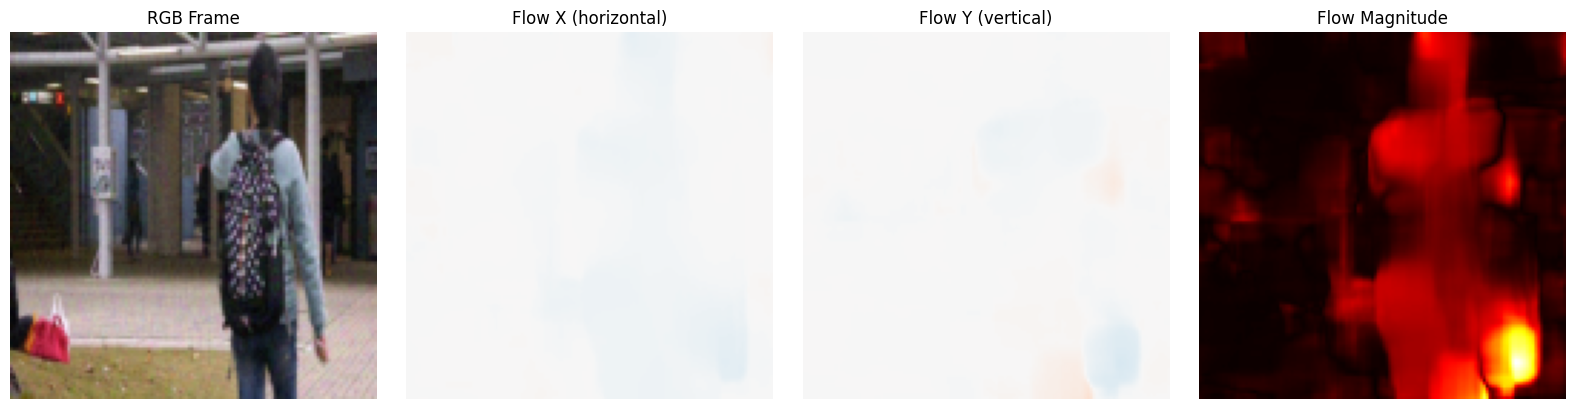

In [9]:
# Visualize sample optical flow
sample_vid = sorted(test_rgb.keys())[0]
sample_idx = 50  # Middle frame

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# RGB frame
rgb_frame = test_rgb[sample_vid][sample_idx].cpu().permute(1, 2, 0).numpy()
rgb_frame = (rgb_frame + 1) / 2  # [-1,1] -> [0,1]
axes[0].imshow(rgb_frame)
axes[0].set_title('RGB Frame')
axes[0].axis('off')

# Flow X (horizontal)
flow_x = test_flow[sample_vid][sample_idx][0].cpu().numpy()
axes[1].imshow(flow_x, cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_title('Flow X (horizontal)')
axes[1].axis('off')

# Flow Y (vertical)
flow_y = test_flow[sample_vid][sample_idx][1].cpu().numpy()
axes[2].imshow(flow_y, cmap='RdBu', vmin=-1, vmax=1)
axes[2].set_title('Flow Y (vertical)')
axes[2].axis('off')

# Flow magnitude
flow_mag = np.sqrt(flow_x**2 + flow_y**2)
axes[3].imshow(flow_mag, cmap='hot')
axes[3].set_title('Flow Magnitude')
axes[3].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'optical_flow_sample.png'))
plt.show()

In [10]:
class SimpleAE(nn.Module):
    """Simple Autoencoder for RGB or Flow."""
    def __init__(self, in_channels=3, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2, True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, True),
        )
        self.fc_enc = nn.Sequential(nn.Flatten(), nn.Linear(512*4*4, latent_dim))
        self.fc_dec = nn.Sequential(nn.Linear(latent_dim, 512*4*4), nn.LeakyReLU(0.2, True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, in_channels, 4, 2, 1), nn.Tanh(),
        )
    
    def forward(self, x):
        z = self.fc_enc(self.encoder(x))
        return self.decoder(self.fc_dec(z).view(-1, 512, 4, 4))

# Test both models
rgb_ae = SimpleAE(in_channels=3, latent_dim=CONFIG['latent_dim']).to(DEVICE)
flow_ae = SimpleAE(in_channels=2, latent_dim=CONFIG['latent_dim']).to(DEVICE)

print(f"RGB AE params: {sum(p.numel() for p in rgb_ae.parameters()):,}")
print(f"Flow AE params: {sum(p.numel() for p in flow_ae.parameters()):,}")

# Test forward
with torch.no_grad():
    test_rgb_input = torch.randn(2, 3, 128, 128, device=DEVICE)
    test_flow_input = torch.randn(2, 2, 128, 128, device=DEVICE)
    print(f"RGB: {test_rgb_input.shape} -> {rgb_ae(test_rgb_input).shape}")
    print(f"Flow: {test_flow_input.shape} -> {flow_ae(test_flow_input).shape}")

RGB AE params: 7,683,523
Flow AE params: 7,682,498
RGB: torch.Size([2, 3, 128, 128]) -> torch.Size([2, 3, 128, 128])
Flow: torch.Size([2, 2, 128, 128]) -> torch.Size([2, 2, 128, 128])


In [11]:
def prepare_all_frames(video_tensors):
    """Flatten all video frames into single tensor."""
    all_frames = []
    for vid in sorted(video_tensors.keys()):
        all_frames.append(video_tensors[vid])
    return torch.cat(all_frames, dim=0)

# Prepare training data
train_rgb_all = prepare_all_frames(train_rgb)
train_flow_all = prepare_all_frames(train_flow)

print(f"Train RGB: {train_rgb_all.shape}")
print(f"Train Flow: {train_flow_all.shape}")

Train RGB: torch.Size([9204, 3, 128, 128])
Train Flow: torch.Size([9204, 2, 128, 128])


In [12]:
def train_ae(model, train_data, config, device, desc="Training"):
    """Train autoencoder model."""
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.MSELoss()
    
    dataset = torch.utils.data.TensorDataset(train_data)
    loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    best_loss = float('inf')
    patience = 0
    best_state = None
    
    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0
        
        for (batch,) in loader:
            optimizer.zero_grad(set_to_none=True)
            loss = criterion(model(batch), batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(loader)
        
        if avg_loss < best_loss - 1e-5:
            best_loss = avg_loss
            patience = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience += 1
        
        if patience >= config['patience']:
            print(f"  {desc}: Early stop at epoch {epoch+1}, loss={best_loss:.6f}")
            break
    
    if best_state:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    
    return model, best_loss

In [13]:
print("=" * 60)
print("TRAINING RGB STREAM (Visual Anomalies)")
print("=" * 60)

rgb_models = []
rgb_losses = []

for i, seed in enumerate(CONFIG['seeds']):
    print(f"\nRGB Model {i+1}/{len(CONFIG['seeds'])} (seed={seed})")
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = SimpleAE(in_channels=3, latent_dim=CONFIG['latent_dim']).to(DEVICE)
    model, loss = train_ae(model, train_rgb_all, CONFIG, DEVICE, f"RGB-{seed}")
    rgb_models.append(model)
    rgb_losses.append(loss)

print(f"\nRGB losses: {[f'{l:.5f}' for l in rgb_losses]}")

TRAINING RGB STREAM (Visual Anomalies)

RGB Model 1/3 (seed=42)

RGB Model 2/3 (seed=123)

RGB Model 3/3 (seed=456)

RGB losses: ['0.00212', '0.00213', '0.00221']


In [14]:
print("=" * 60)
print("TRAINING FLOW STREAM (Motion Anomalies)")
print("=" * 60)

flow_models = []
flow_losses = []

for i, seed in enumerate(CONFIG['seeds']):
    print(f"\nFlow Model {i+1}/{len(CONFIG['seeds'])} (seed={seed})")
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = SimpleAE(in_channels=2, latent_dim=CONFIG['latent_dim']).to(DEVICE)
    model, loss = train_ae(model, train_flow_all, CONFIG, DEVICE, f"Flow-{seed}")
    flow_models.append(model)
    flow_losses.append(loss)

print(f"\nFlow losses: {[f'{l:.5f}' for l in flow_losses]}")

TRAINING FLOW STREAM (Motion Anomalies)

Flow Model 1/3 (seed=42)

Flow Model 2/3 (seed=123)
  Flow-123: Early stop at epoch 22, loss=0.000077

Flow Model 3/3 (seed=456)
  Flow-456: Early stop at epoch 25, loss=0.000067

Flow losses: ['0.00008', '0.00008', '0.00007']


In [15]:
@torch.no_grad()
def compute_max_scores(model, video_tensors, video_fnums):
    """Compute MAX reconstruction error per frame."""
    model.eval()
    scores = {}
    
    for vid in tqdm(video_tensors.keys(), desc="Scoring"):
        tensors = video_tensors[vid]
        fnums = video_fnums[vid]
        
        # Process in batches
        batch_size = 64
        for start in range(0, len(tensors), batch_size):
            end = min(start + batch_size, len(tensors))
            batch = tensors[start:end]
            recon = model(batch)
            
            max_err = torch.amax((batch - recon) ** 2, dim=(1, 2, 3))
            
            for i, err in enumerate(max_err.cpu().numpy()):
                fnum = fnums[start + i]
                scores[f"{vid}_{fnum}"] = float(err)
    
    return scores

In [16]:
print("Computing RGB scores...")
rgb_scores_all = []
for i, model in enumerate(rgb_models):
    print(f"  RGB Model {i+1}...")
    scores = compute_max_scores(model, test_rgb, test_fnums)
    rgb_scores_all.append(scores)

print("\nComputing Flow scores...")
flow_scores_all = []
for i, model in enumerate(flow_models):
    print(f"  Flow Model {i+1}...")
    scores = compute_max_scores(model, test_flow, test_fnums)
    flow_scores_all.append(scores)

print(f"\nRGB scores: {len(rgb_scores_all[0])}")
print(f"Flow scores: {len(flow_scores_all[0])}")

Computing RGB scores...
  RGB Model 1...


Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

  RGB Model 2...


Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

  RGB Model 3...


Scoring:   0%|          | 0/21 [00:00<?, ?it/s]


Computing Flow scores...
  Flow Model 1...


Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

  Flow Model 2...


Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

  Flow Model 3...


Scoring:   0%|          | 0/21 [00:00<?, ?it/s]


RGB scores: 11706
Flow scores: 11706


In [17]:
def normalize(scores, clip_pct=99):
    vals = np.array(list(scores.values()))
    keys = list(scores.keys())
    clip_val = np.percentile(vals, clip_pct)
    vals = np.clip(vals, 0, clip_val)
    v_min, v_max = vals.min(), vals.max()
    if v_max > v_min:
        norm = (vals - v_min) / (v_max - v_min)
    else:
        norm = np.ones_like(vals) * 0.5
    return {k: float(norm[i]) for i, k in enumerate(keys)}

def ensemble_mean(score_list):
    keys = list(score_list[0].keys())
    return {k: np.mean([s[k] for s in score_list]) for k in keys}

# Normalize individual scores
rgb_norm = [normalize(s) for s in rgb_scores_all]
flow_norm = [normalize(s) for s in flow_scores_all]

# Ensemble within each stream
rgb_ensemble = normalize(ensemble_mean(rgb_norm))
flow_ensemble = normalize(ensemble_mean(flow_norm))

print("Created RGB and Flow ensembles")

Created RGB and Flow ensembles


In [18]:
# Fusion strategies
def fuse_scores(rgb_scores, flow_scores, rgb_weight, flow_weight):
    fused = {}
    for fid in rgb_scores.keys():
        fused[fid] = rgb_weight * rgb_scores.get(fid, 0) + flow_weight * flow_scores.get(fid, 0)
    return normalize(fused, clip_pct=100)

FUSION_WEIGHTS = {
    'rgb_only': (1.0, 0.0),
    'flow_only': (0.0, 1.0),
    'rgb70_flow30': (0.7, 0.3),
    'rgb60_flow40': (0.6, 0.4),
    'rgb50_flow50': (0.5, 0.5),
    'rgb40_flow60': (0.4, 0.6),
    'rgb30_flow70': (0.3, 0.7),
}

fused_scores = {}
for name, (rw, fw) in FUSION_WEIGHTS.items():
    fused_scores[name] = fuse_scores(rgb_ensemble, flow_ensemble, rw, fw)
    print(f"Created: {name}")

Created: rgb_only
Created: flow_only
Created: rgb70_flow30
Created: rgb60_flow40
Created: rgb50_flow50
Created: rgb40_flow60
Created: rgb30_flow70


In [19]:
# Also try max fusion (take max of RGB and Flow)
def fuse_max(rgb_scores, flow_scores):
    fused = {}
    for fid in rgb_scores.keys():
        fused[fid] = max(rgb_scores.get(fid, 0), flow_scores.get(fid, 0))
    return normalize(fused, clip_pct=100)

fused_scores['max_fusion'] = fuse_max(rgb_ensemble, flow_ensemble)
print("Created: max_fusion")

# Product fusion (multiply - both must agree)
def fuse_product(rgb_scores, flow_scores):
    fused = {}
    for fid in rgb_scores.keys():
        fused[fid] = rgb_scores.get(fid, 0) * flow_scores.get(fid, 0)
    return normalize(fused, clip_pct=100)

fused_scores['product_fusion'] = fuse_product(rgb_ensemble, flow_ensemble)
print("Created: product_fusion")

Created: max_fusion
Created: product_fusion


In [20]:
def save_sub(scores, filename):
    df = pd.DataFrame([{'Id': fid, 'Predicted': scores.get(fid, 0)} for fid in test_frame_ids])
    path = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(path, index=False)
    print(f"Saved: {filename}")
    return df

print("Generating submissions...")
print("-" * 40)

submissions = {}
for name, scores in fused_scores.items():
    submissions[name] = save_sub(scores, f'sub_{name}.csv')

print("-" * 40)
print(f"Generated {len(submissions)} submissions")

Generating submissions...
----------------------------------------
Saved: sub_rgb_only.csv
Saved: sub_flow_only.csv
Saved: sub_rgb70_flow30.csv
Saved: sub_rgb60_flow40.csv
Saved: sub_rgb50_flow50.csv
Saved: sub_rgb40_flow60.csv
Saved: sub_rgb30_flow70.csv
Saved: sub_max_fusion.csv
Saved: sub_product_fusion.csv
----------------------------------------
Generated 9 submissions


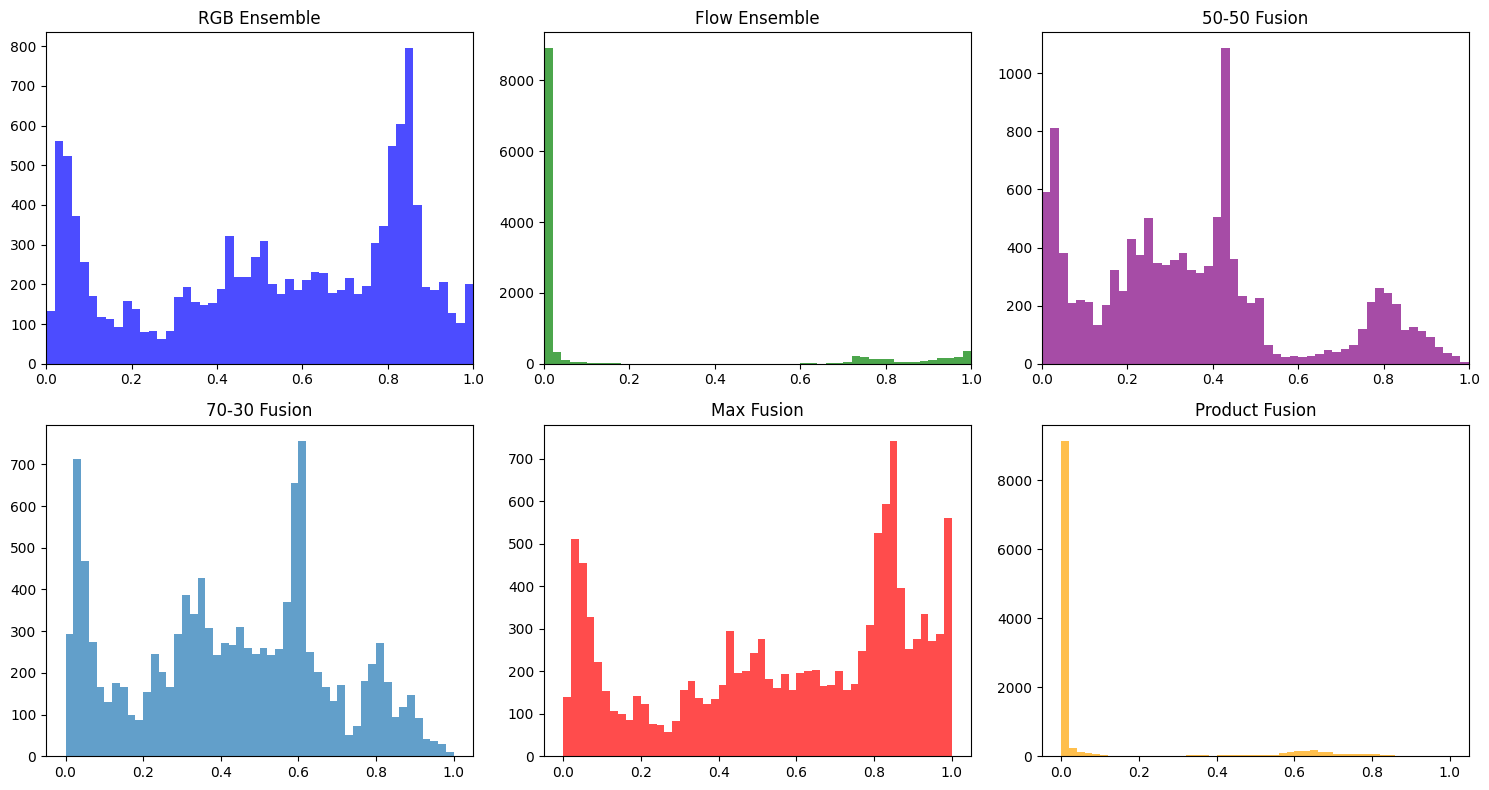

In [21]:
# Compare RGB vs Flow score distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0, 0].hist(list(rgb_ensemble.values()), bins=50, alpha=0.7, color='blue')
axes[0, 0].set_title('RGB Ensemble')
axes[0, 0].set_xlim(0, 1)

axes[0, 1].hist(list(flow_ensemble.values()), bins=50, alpha=0.7, color='green')
axes[0, 1].set_title('Flow Ensemble')
axes[0, 1].set_xlim(0, 1)

axes[0, 2].hist(list(fused_scores['rgb50_flow50'].values()), bins=50, alpha=0.7, color='purple')
axes[0, 2].set_title('50-50 Fusion')
axes[0, 2].set_xlim(0, 1)

axes[1, 0].hist(list(fused_scores['rgb70_flow30'].values()), bins=50, alpha=0.7)
axes[1, 0].set_title('70-30 Fusion')

axes[1, 1].hist(list(fused_scores['max_fusion'].values()), bins=50, alpha=0.7, color='red')
axes[1, 1].set_title('Max Fusion')

axes[1, 2].hist(list(fused_scores['product_fusion'].values()), bins=50, alpha=0.7, color='orange')
axes[1, 2].set_title('Product Fusion')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'fusion_distributions.png'))
plt.show()

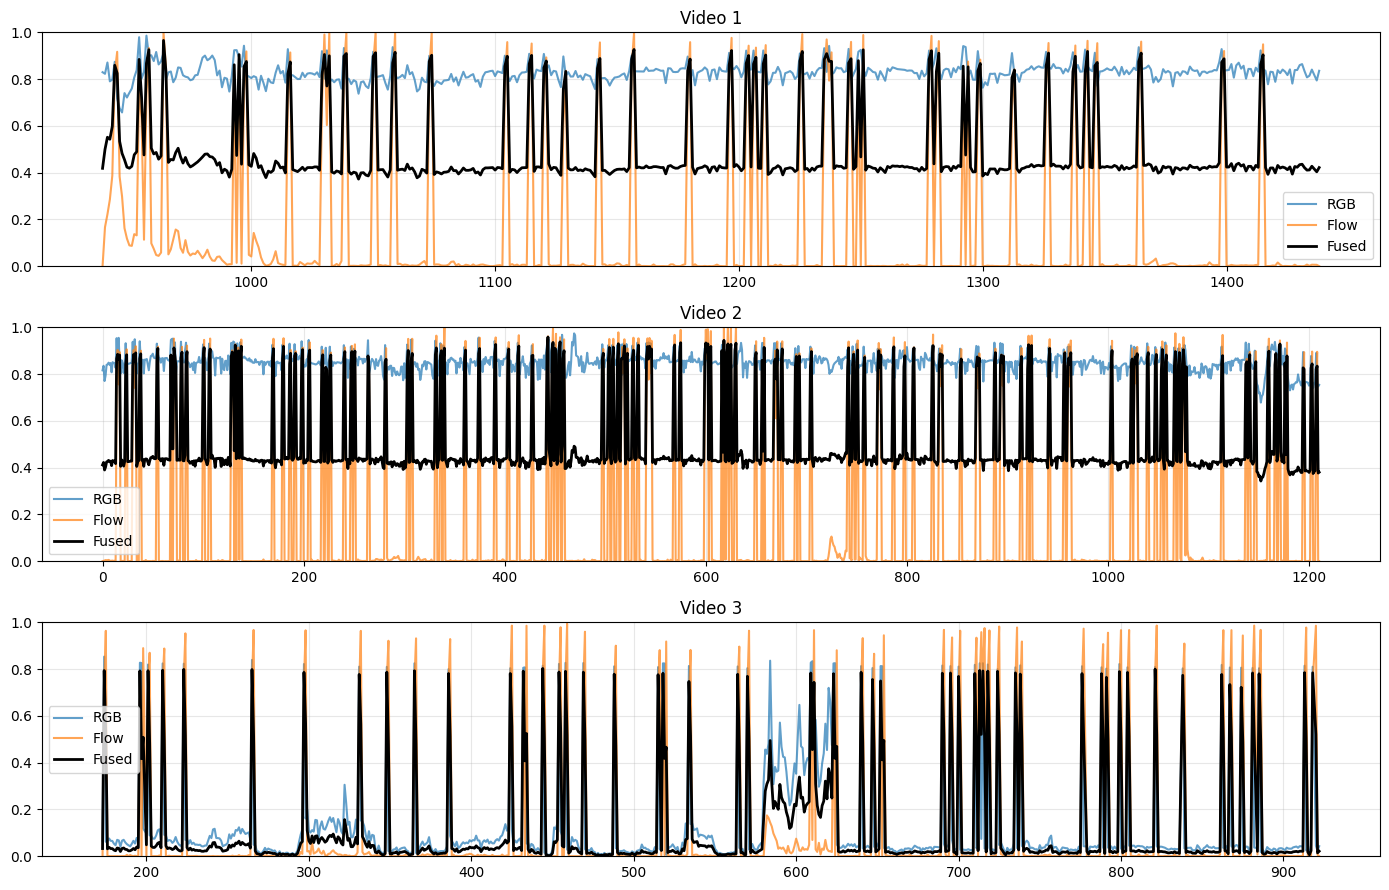

In [22]:
# Temporal visualization
n_vids = min(3, len(test_rgb))
fig, axes = plt.subplots(n_vids, 1, figsize=(14, 3*n_vids))
if n_vids == 1:
    axes = [axes]

for idx, vid in enumerate(sorted(test_rgb.keys())[:n_vids]):
    fnums = test_fnums[vid]
    
    rgb_s = [rgb_ensemble.get(f"{vid}_{f}", 0) for f in fnums]
    flow_s = [flow_ensemble.get(f"{vid}_{f}", 0) for f in fnums]
    fused_s = [fused_scores['rgb50_flow50'].get(f"{vid}_{f}", 0) for f in fnums]
    
    axes[idx].plot(fnums, rgb_s, label='RGB', alpha=0.7)
    axes[idx].plot(fnums, flow_s, label='Flow', alpha=0.7)
    axes[idx].plot(fnums, fused_s, label='Fused', linewidth=2, color='black')
    
    axes[idx].set_title(f'Video {vid}')
    axes[idx].set_ylim(0, 1)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'temporal_comparison.png'))
plt.show()

In [23]:
# Cleanup
del train_rgb, train_flow, train_rgb_all, train_flow_all
del test_rgb, test_flow
gc.collect()
torch.cuda.empty_cache()
print("Cleanup done!")

Cleanup done!
